In [1]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, confusion_matrix

#Define Helper Functions 
def calc_prevalence(y_actual):
    return (sum(y_actual) / len(y_actual))

def calc_specificity(y_actual, y_pred_probs, thresh):
    return sum((y_pred_probs < thresh) & (y_actual == 0)) / sum(y_actual == 0)

def print_report(y_actual, y_pred_probs, thresh=0.5):
    auc = roc_auc_score(y_actual, y_pred_probs)
    accuracy = accuracy_score(y_actual, (y_pred_probs > thresh))
    recall = recall_score(y_actual, (y_pred_probs > thresh))
    precision = precision_score(y_actual, (y_pred_probs > thresh))
    specificity = calc_specificity(y_actual, y_pred_probs, thresh)
    
    print(f"AUC: {auc:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Recall (Sensitivity): {recall:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print(f"Prevalence: {calc_prevalence(y_actual):.3f}")
    print(' ')
    
    return auc, accuracy, recall, precision, specificity

#Load the Cleaned Dataset
diabetes_cleaned = pd.read_csv('/workspaces/SP25-Project/data/diabetes_cleaned.csv')

#Clean and Prepare Data
diabetes_cleaned = diabetes_cleaned[diabetes_cleaned['gender'] != 'Unknown/Invalid']

feature_cols = [
    'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
    'num_procedures', 'num_medications', 'number_outpatient',
    'number_emergency', 'number_inpatient', 'number_diagnoses',
    'max_glu_serum_binary', 'A1Cresult_binary',
    'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other'
]

X = diabetes_cleaned[feature_cols]
y = diabetes_cleaned['readmitted_binary']

#Split Train/Test
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Balance the Training Set
rows_pos = y_train == 1
df_train_pos = X_train.loc[rows_pos]
df_train_neg = X_train.loc[~rows_pos]

df_train_neg_bal = df_train_neg.sample(n=len(df_train_pos), random_state=111)

X_train_balanced = pd.concat([df_train_pos, df_train_neg_bal], axis=0)
y_train_balanced = np.concatenate([np.ones(len(df_train_pos)), np.zeros(len(df_train_pos))])

X_train_balanced = X_train_balanced.sample(n=len(X_train_balanced), random_state=42).reset_index(drop=True)
y_train_balanced = pd.Series(y_train_balanced).sample(frac=1, random_state=42).reset_index(drop=True)

print('Training Balanced Prevalence (n = %d): %.3f' % (len(y_train_balanced), calc_prevalence(y_train_balanced)))

#Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

#Predict on Validation Set
y_valid_preds_rf = rf_model.predict_proba(X_valid)[:, 1]

#Evaluate Random Forest
print('Metrics for Validation Data (Random Forest, Threshold = 0.5):')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(
    y_valid, y_valid_preds_rf, thresh=0.5
)


/tmp/ipykernel_16069/2130790318.py:33: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  diabetes_cleaned = pd.read_csv('/workspaces/SP25-Project/data/diabetes_cleaned.csv')


Training Balanced Prevalence (n = 18172): 0.500
Metrics for Validation Data (Random Forest, Threshold = 0.5):
AUC: 0.610
Accuracy: 0.586
Recall (Sensitivity): 0.560
Precision: 0.146
Specificity: 0.566
Prevalence: 0.112
 


# Metric Explanations

## 1. Training Balanced Prevalence = 0.500
- After manual balancing, training data has 50% positive and 50% negative examples.
- Ensures the model does not bias heavily toward the majority class.

## 2. AUC = 0.610
- Measures the model’s ability to distinguish between readmitted and non-readmitted patients.
- 0.5 = random guessing, 1.0 = perfect prediction.
- 0.610 suggests **modest discrimination ability**.

## 3. Accuracy = 0.586
- 58.6% of total predictions were correct.
- Accuracy is not the best measure here due to data imbalance (only 11% positives).

## 4. Recall (Sensitivity) = 0.560
- **56%** of true readmissions were correctly identified.
- **Higher recall is preferred** in healthcare settings to avoid missing high-risk patients.

## 5. Precision = 0.146
- Only 14.6% of the patients predicted as "readmitted" were actually readmitted.
- Indicates a high false positive rate, but acceptable if the goal is to catch as many true readmissions as possible.

## 6. Specificity = 0.566
- About 56.6% of true non-readmissions were correctly identified.
- Balances the model's ability to reject non-readmitted patients.

## 7. Prevalence = 0.112
- Only 11.2% of the total population actually gets readmitted.
- Shows that the dataset is heavily imbalanced.

---

# Overall Interpretation
- The Random Forest model **catches more real readmissions** (higher Recall) compared to Logistic Regression.
- **Precision is lower**, meaning more false positives are flagged.
- **AUC is modest (0.610)**, suggesting the model can distinguish readmissions better than random but still has room for improvement.
- **Accuracy dropped** compared to Logistic Regression, expected when prioritizing Recall over overall correctness.

---

# Quick Comparison: Logistic Regression vs Random Forest

| Metric | Logistic Regression | Random Forest |
|:-------|:--------------------|:--------------|
| **AUC** | 0.640 | 0.610 |
| **Accuracy** | 0.677 | 0.586 |
| **Recall** | 0.488 | 0.560 |
| **Precision** | 0.170 | 0.146 |
| **Specificity** | 0.701 | 0.566 |

---

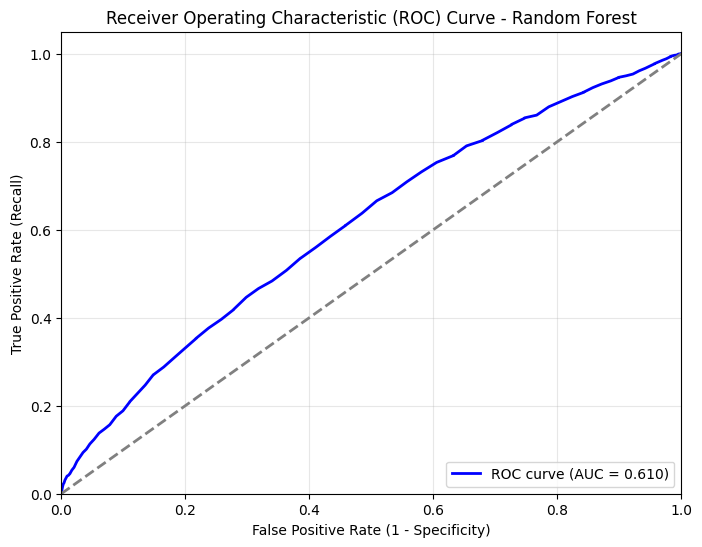

In [2]:
#Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#Calculate ROC Curve values
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_preds_rf)
roc_auc = auc(fpr, tpr)

#lot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


## 1. Shape of the ROC Curve
- The blue curve lies **above the diagonal** (random guessing line).
- This confirms the model performs **better than random** at distinguishing between patients who will and will not be readmitted.
- A perfect model would hug the **top-left corner** (high Recall, low False Positives).

## 2. AUC = 0.610
- **Area Under the Curve (AUC)** = 0.610.
- **Meaning:** There is a 61% chance that the model will assign a higher predicted probability to a randomly chosen positive case than to a randomly chosen negative case.
- AUC > 0.5 indicates **useful model performance**, although there is significant room for improvement.
